Generate combination signal

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import sounddevice as sd

In [118]:
from scipy.signal import chirp
from math import  floor,ceil
from random import  random
def cos_signal(freq,t,a=1,phase=0):
     return np.cos(2*np.pi*freq*t+phase*np.pi)
def chirp_signal(freq,t,a=1):
     return chirp(t,f0=freq-5,f1=freq,t1=1)
signal_basis=[cos_signal,chirp_signal]
def str2sig(data,freq_min,freq_max,clock_time,sampling_rate,ampitude=1,phase=0):

     tmp=[]
     N=len(data)
     sampling = sampling_rate
     t=np.linspace(0,clock_time,ceil(sampling*clock_time))
     print(data,freq_min,freq_max,clock_time,sampling_rate*clock_time)
     for i in data:
          match i:
               case '1':tmp.append(signal_basis[0](freq_max,t,phase=np.pi*(random())))
               case '0':tmp.append(signal_basis[0](freq_min,t,phase=np.pi*(random())))
               case '2':tmp.append(t*0)
     x=np.concatenate(tmp)
     plt.figure(figsize=(60,5))
     plt.plot(np.linspace(0,N*clock_time,N*ceil(sampling*clock_time)),x)
     return x
     
def generator_signal(data,freq_padding,time_per_changed,times,sampling_rate=-1):
     
     y_in=[]
     N=len(data)
     maxnum_per_freq=int(floor(times/time_per_changed))
     times=maxnum_per_freq*time_per_changed # fitting time with time_per_changes
     level = int(math.ceil((N/maxnum_per_freq)))
     padding_char = '2'*(level*maxnum_per_freq-N)
     data=data + (padding_char)
     segment_freq=[ [i*freq_padding,(i+1)*freq_padding] for i in range(1,2*level,2)]
     sampling_freq = max( 4*(2*level)*freq_padding,sampling_rate)
     datas = [data[maxnum_per_freq*i:min(maxnum_per_freq*(i)+maxnum_per_freq,len(data))] for i in range(level)]
     y_out=np.zeros(ceil(sampling_freq*time_per_changed)*maxnum_per_freq)
     print(times*sampling_freq)
     for i in range(level):
          tmp=str2sig(datas[i],segment_freq[i][0],segment_freq[i][1],time_per_changed,sampling_freq,phase=(i*np.pi/level))
          y_in.append(tmp)
          y_out+=tmp
     plt.figure(figsize=(60,5))
     plt.plot(np.linspace(0,times,ceil(sampling_freq*time_per_changed)*maxnum_per_freq),y_out)
     return [segment_freq,y_out,y_in,datas,sampling_freq,freq_padding,times,time_per_changed]

01101000011001010110110001101100011011110010000001110111011010000110111100100000011100100010000001110101
13312.0
01101000 32 64 0.5 1664.0
01100101 96 128 0.5 1664.0
01101100 160 192 0.5 1664.0
01101100 224 256 0.5 1664.0
01101111 288 320 0.5 1664.0
00100000 352 384 0.5 1664.0
01110111 416 448 0.5 1664.0
01101000 480 512 0.5 1664.0
01101111 544 576 0.5 1664.0
00100000 608 640 0.5 1664.0
01110010 672 704 0.5 1664.0
00100000 736 768 0.5 1664.0
01110101 800 832 0.5 1664.0


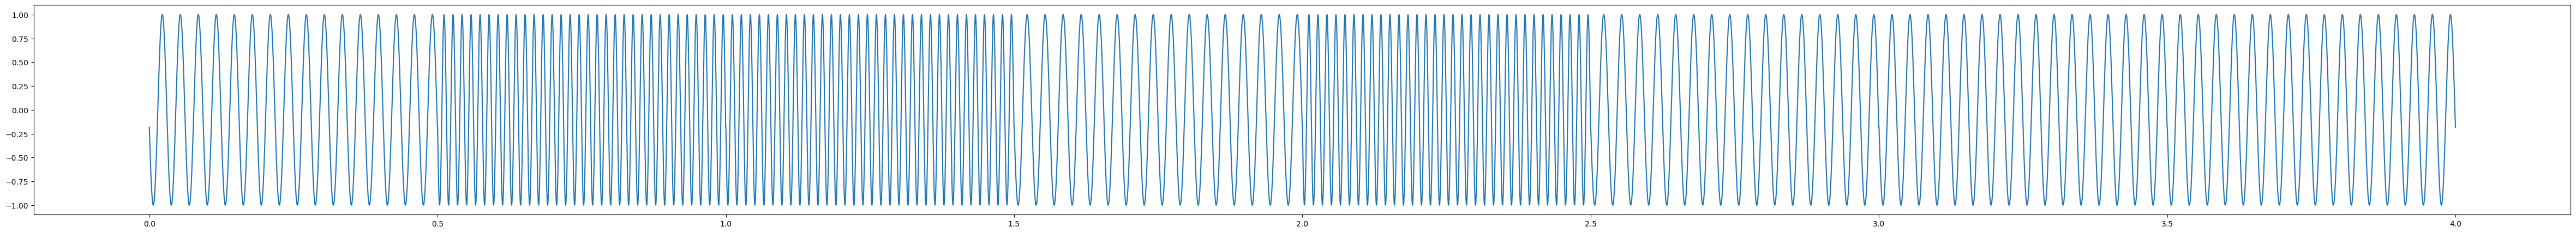

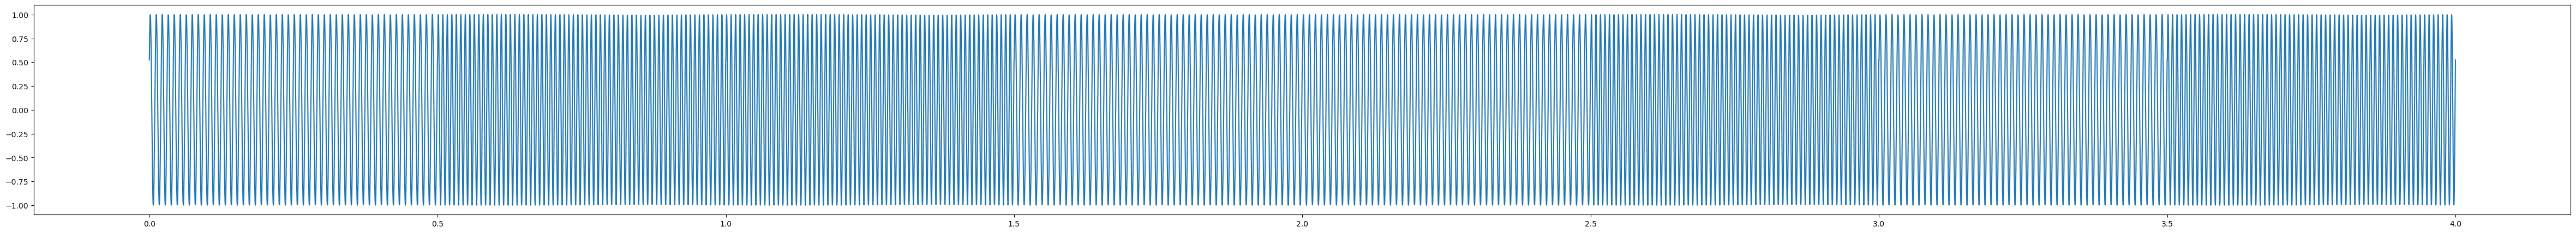

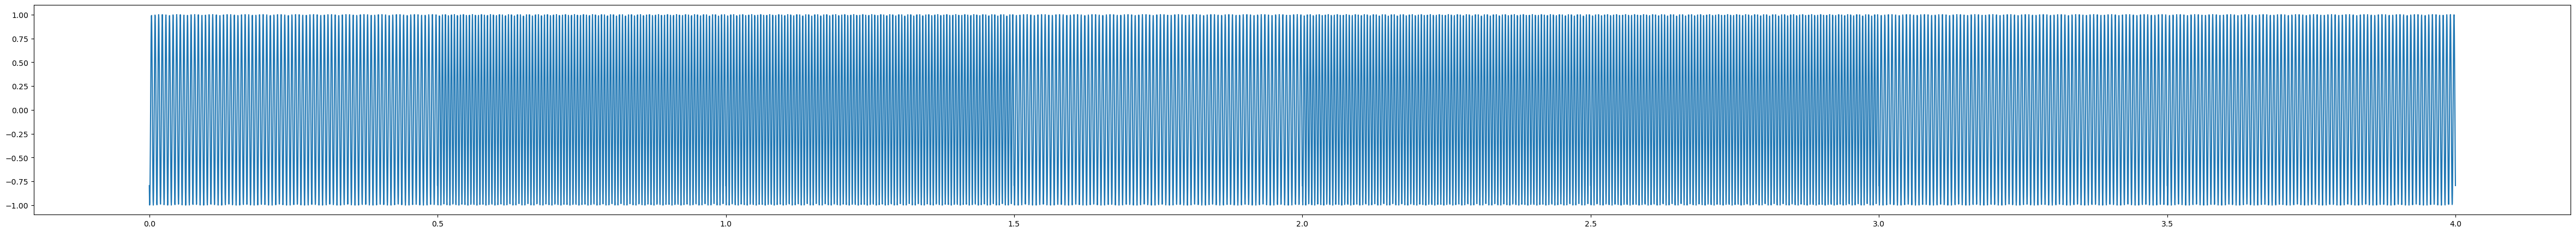

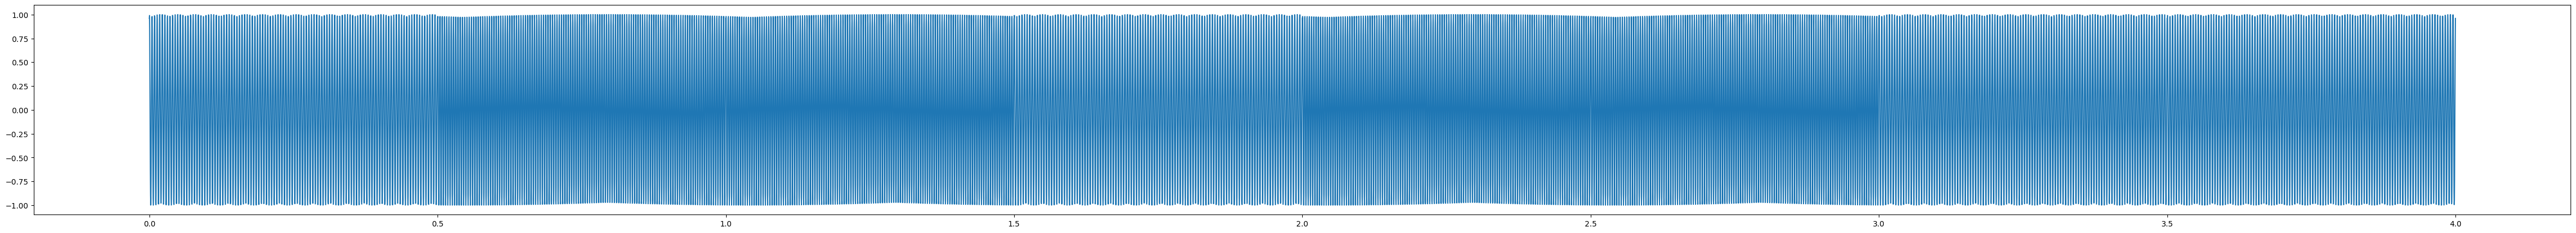

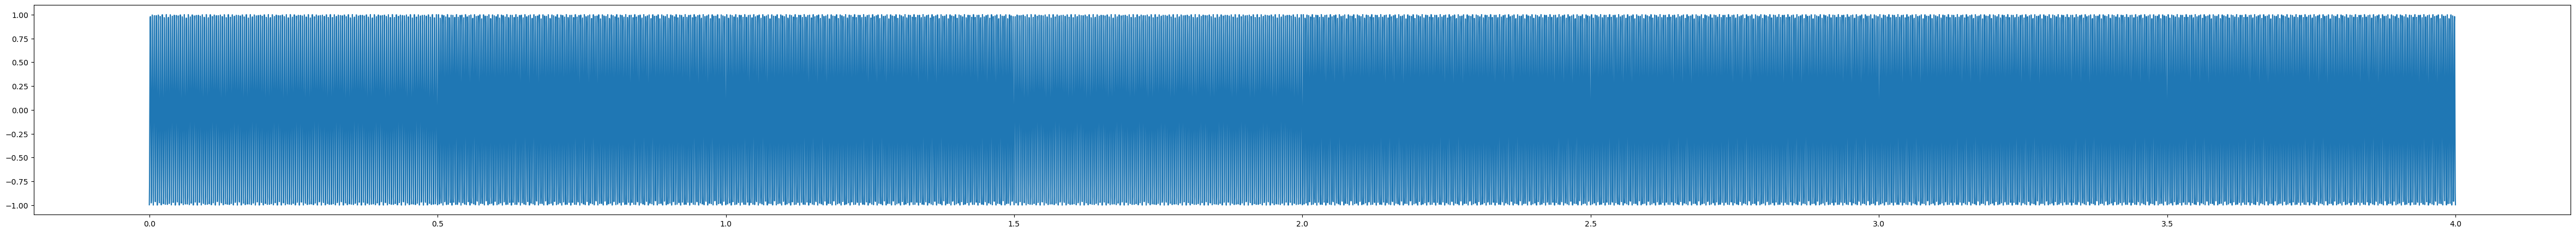

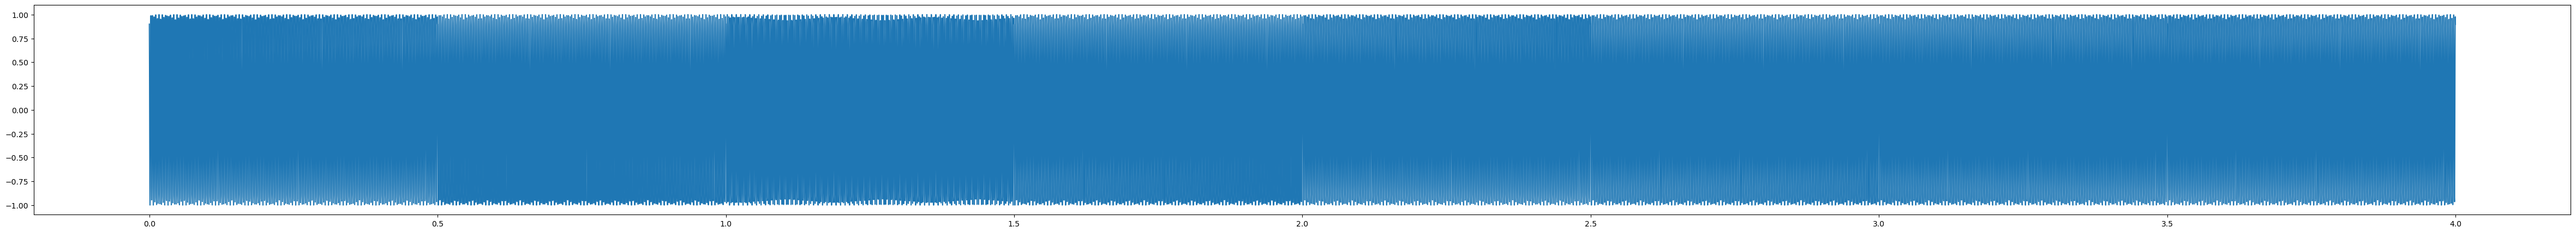

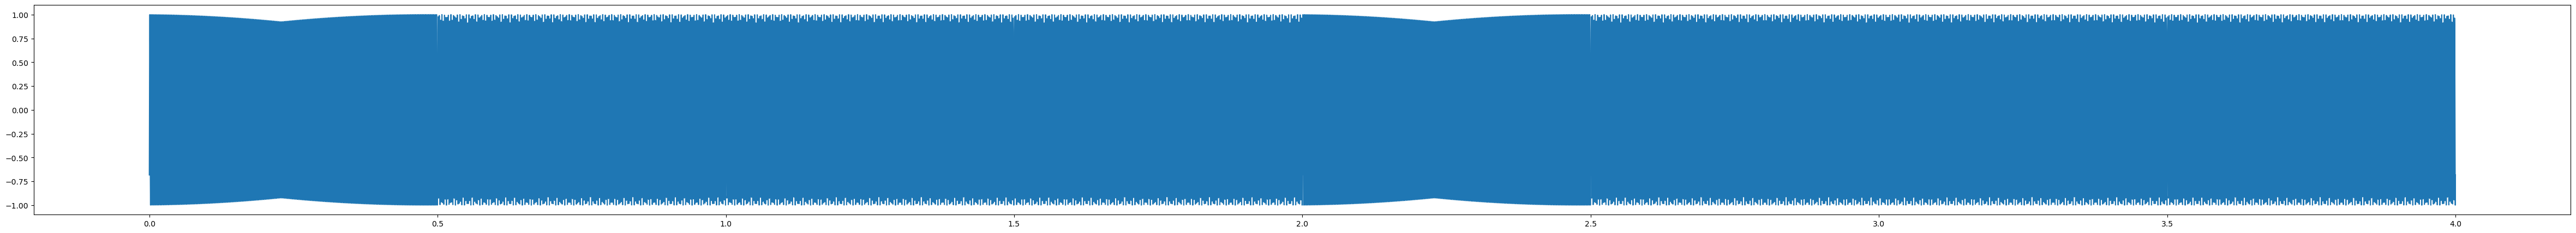

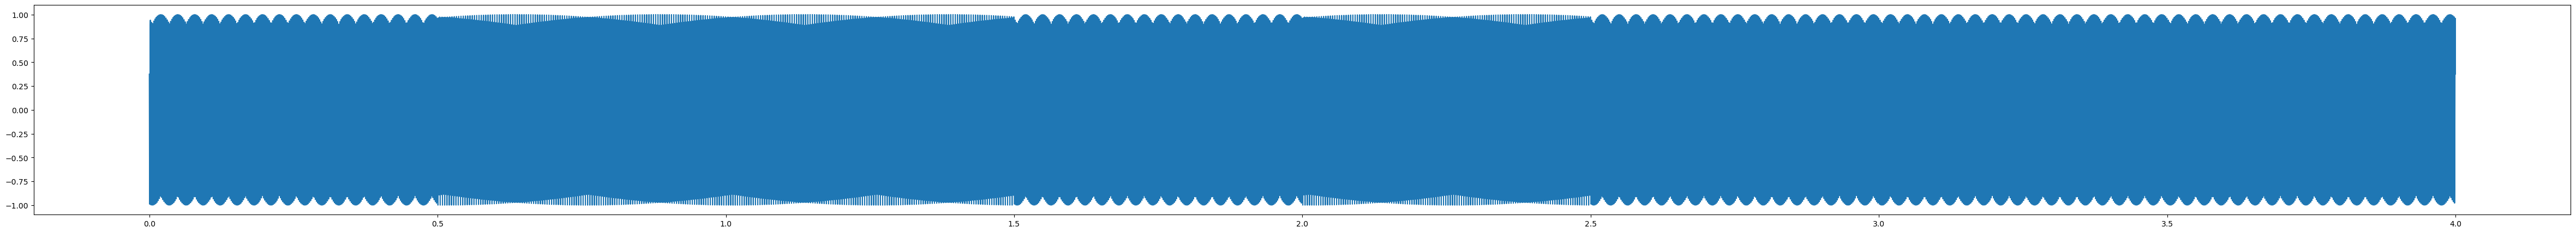

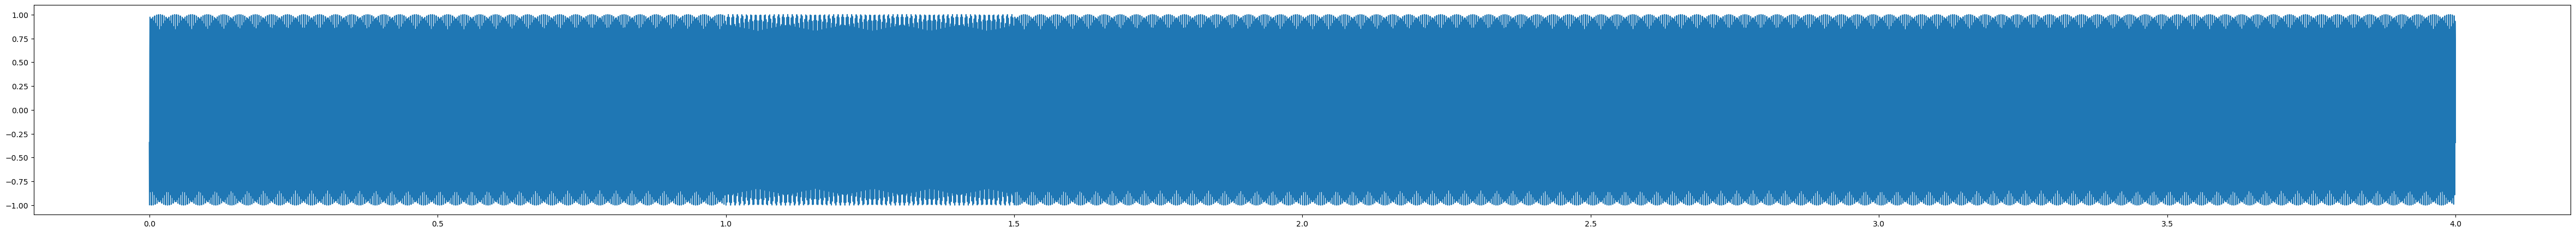

In [117]:
test_str="hello who r u"
res = str(''.join(format(ord(i), '08b') for i in test_str))
print(res)


segment_freq,comb_signal,input_seperate_signal,datas,sampling_freq,freq_padding,time_all,time_per_segment=generator_signal(res,32,0.5,4)



Decompose and Analysis

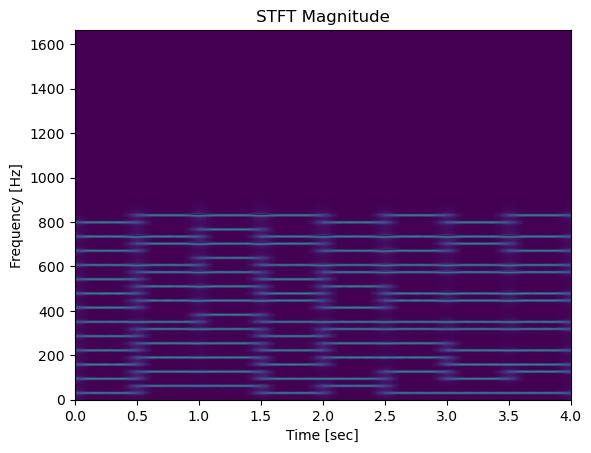

In [119]:
from scipy.signal  import stft,windows

nperseg=sampling_freq//4
f, t, Zxx = stft(comb_signal, sampling_freq, nperseg=nperseg,window=windows.hann(nperseg))

plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=1, shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


In [ ]:
sd.play(comb_signal,samplerate=sampling_freq)

Convert to binary

2160

540

540

In [107]:
t


array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
       1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125,
       2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   , 3.125, 3.25 ,
       3.375, 3.5  , 3.625, 3.75 , 3.875, 4.   , 4.125])

8

In [121]:
freq_factor  =  sampling_freq//nperseg
print(freq_factor)
assess_segment=[]
decode_data = []
lenght_time = int(math.floor((len(t)/time_all)*time_per_segment))
print(lenght_time)
for index,(freq_min,freq_max) in enumerate(segment_freq):
     freq_min=max(0,freq_min-freq_padding//2)
     freq_max=max(0,freq_max+freq_padding//2)
     freq_mid = int((freq_max+freq_min)/2)
     
    
     print(freq_min,":",f[max(0,math.floor(freq_min/freq_factor))],freq_mid,":",f[min(math.ceil(freq_mid/freq_factor),len(f)-1)])
     


     for i in range(len(t)//lenght_time):
          
          index_min= max(0,math.floor(freq_min/freq_factor))
          index_mid = min(math.ceil(freq_mid//freq_factor),len(f)-1)
          index_max = min(math.ceil(freq_max//freq_factor),len(f)-1)
          print(t[i*lenght_time:((i+1)*lenght_time)],f"freq-raneg:{f[index_min]}|{f[index_mid]}| {f[index_max]}")
          index_time_min = max(0,i*lenght_time+1)
          index_time_max = min(len(t)-1,(i+1)*lenght_time)
          
          lowband_freq_avg = np.mean(np.abs(Zxx[index_min:index_mid,index_time_min:index_time_max]))
          highband_freq_avg = np.mean(np.abs(Zxx[index_mid:index_max,index_time_min:index_time_max]))
          print(lowband_freq_avg,highband_freq_avg)
          if(lowband_freq_avg<0.1 and highband_freq_avg<0.1): 
               decode_data.append('2')
          elif lowband_freq_avg > highband_freq_avg:
               decode_data.append('0')
          else: decode_data.append('1')

          #assess_segment.append([freq_min,freq_mid,freq_max])
text_data = ''.join(decode_data)
print(text_data)


4
4
16 : 16.0 48 : 48.0
[0.    0.125 0.25  0.375] freq-raneg:16.0|48.0| 80.0
0.12523897640472545 3.482679444565743e-05
[0.5   0.625 0.75  0.875] freq-raneg:16.0|48.0| 80.0
3.345742852973366e-06 0.12536727969990943
[1.    1.125 1.25  1.375] freq-raneg:16.0|48.0| 80.0
3.347990723632841e-06 0.1253672795668551
[1.5   1.625 1.75  1.875] freq-raneg:16.0|48.0| 80.0
0.1252389764140989 3.482721389735532e-05
[2.    2.125 2.25  2.375] freq-raneg:16.0|48.0| 80.0
3.3111208630021726e-06 0.12537214673646604
[2.5   2.625 2.75  2.875] freq-raneg:16.0|48.0| 80.0
0.12523890915758853 2.628610298016378e-05
[3.    3.125 3.25  3.375] freq-raneg:16.0|48.0| 80.0
0.12523897671636378 3.482155359025227e-05
[3.5   3.625 3.75  3.875] freq-raneg:16.0|48.0| 80.0
0.1252389071628305 2.6277541913635754e-05
80 : 80.0 112 : 112.0
[0.    0.125 0.25  0.375] freq-raneg:80.0|112.0| 144.0
0.12549587540789683 7.009356045981848e-05
[0.5   0.625 0.75  0.875] freq-raneg:80.0|112.0| 144.0
5.306957551907429e-05 0.12562204862433957
[

FIltering Frequency 

In [ ]:

filter_mask=[]
for index,(freq_min,freq_max) in enumerate(segment_freq):
     print(freq_min,freq_max)
     freq_min=max(0,freq_min-freq_padding//2)
     freq_max=max(0,freq_max+freq_padding//2)
     mask = (np.arange(np.min(f),np.max(f)+f[1]-f[0],f[1]-f[0])<freq_min) | (np.arange(np.min(f),np.max(f)+f[1]-f[0],f[1]-f[0])>freq_max) 
     filter_mask.append(mask)

30 60
90 120
150 180
210 240
270 300
330 360
390 420
450 480
510 540
570 600
630 660
690 720
750 780
810 840
870 900
930 960
990 1020
1050 1080


In [10]:
Zxx_expanded = np.expand_dims(Zxx, axis=0)  

filter_Zxx = np.tile(Zxx_expanded, (len(segment_freq), 1, 1))
for index,mask in enumerate(filter_mask):
     filter_Zxx[index][mask]=0

     

In [11]:

freq_idx = np.where(f<=1200)
f_limit = f[freq_idx]
zxx_limit = filter_Zxx[10][freq_idx,:][0]
t

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
       1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125,
       2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   ])

In [13]:
plt.pcolormesh(np.linspace(0,5,25), f[freq_idx], np.abs(zxx_limit), vmin=0, vmax=1, shading='gouraud')

In [ ]:
from scipy.signal import istft
decompose_signal=[]
for filtered_Zxx in filter_Zxx:
     t,x = istft(filtered_Zxx,fs=sampling_freq,nperseg=nperseg,window=windows.hann(nperseg))
     x=x/np.max(x)
     print(x)
     decompose_signal.append([t,x])

     

[0.44784958 0.4466816  0.44548081 ... 0.44465882 0.44566479 0.44663799]
[0.43445341 0.44059529 0.44666357 ... 0.44825299 0.44080229 0.43327789]
[0.46105731 0.46514766 0.46893038 ... 0.01555081 0.00902535 0.00249487]


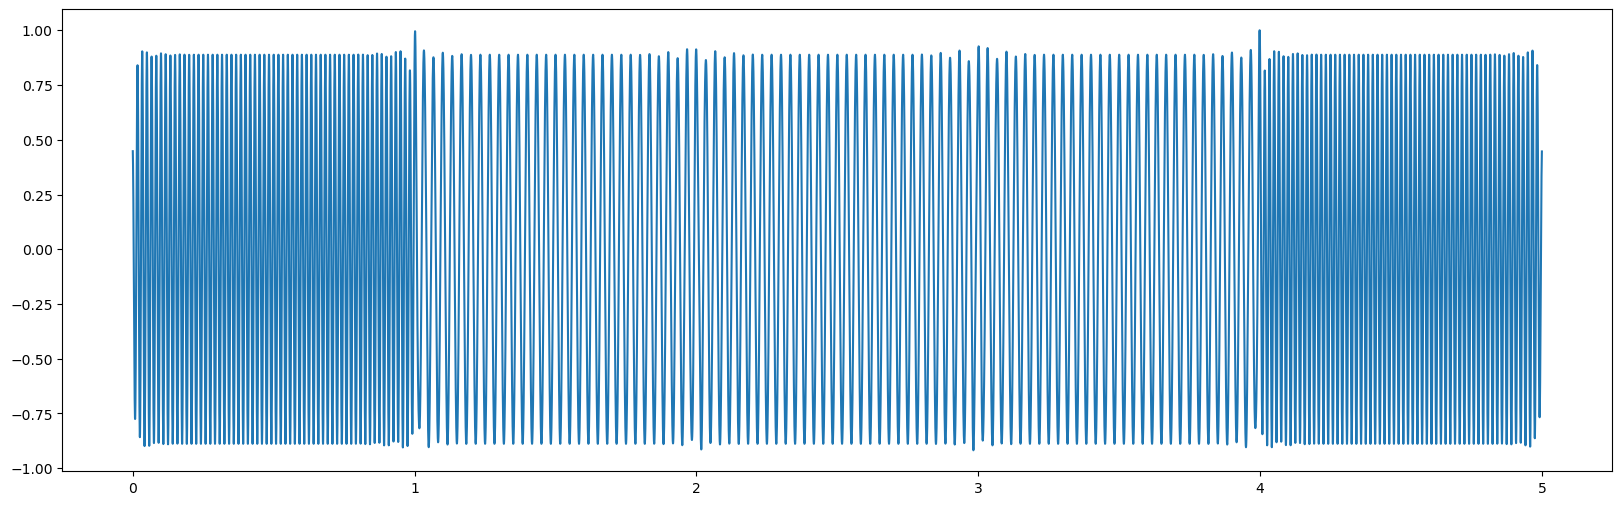

In [ ]:
tmp=np.linspace(0,len(decompose_signal[0][1])//sampling_freq,len(decompose_signal[0][1]))
plt.figure(figsize=(20,6))
plt.plot(tmp,decompose_signal[0][1])


Signal similarity Analysis

In [ ]:
input_seperate_signal[0]

array([1.        , 0.76521124, 0.17109648, ..., 0.17109648, 0.76521124,
       1.        ], shape=(2700,))

In [ ]:

from scipy.signal import  correlate
c_out = correlate(input_seperate_signal[0],decompose_signal[0][1])
c1_out = correlate(input_seperate_signal[0],input_seperate_signal[0])
(np.max(c_out)/np.max(c1_out))*100